In [1]:
import tensorflow as tf
import numpy as np
from memory import Memory
from basics import Basics
from tqdm import tqdm


from networks_kennedy import QN_l1, QN_guess_kennedy
import give_probability_kennedy




basics = Basics(layers=1)
basics.define_actions()
b =np.load("buffer.npy", allow_pickle=True)
buffer = Memory(len(b), load_path=None)
for i in range(len(b)):
    buffer.add_sample(tuple(b[i]))


In [2]:
q= np.zeros((2,11,2))
n= np.zeros((2,11,2))
q0= np.zeros((11))
n0= np.zeros((11))

qalph= np.zeros((2,11,2))
q0alph= np.zeros((11))

alpha = 1/buffer.num_samples

for v in tqdm(buffer.samples):
    n[tuple([int(v[0]), int(v[2]),int(v[4])])] += 1
    nn= n[tuple([int(v[0]), int(v[2]),int(v[4])])]
    q[tuple([int(v[0]), int(v[2]),int(v[4])])] =  (1- (1/nn))*q[tuple([int(v[0]), int(v[2]),int(v[4])])] + (v[5])/nn

    n0[tuple([int(v[2])])] += 1
    nn0= n0[tuple([int(v[2])])] 
    q0[tuple([int(v[2])])] =  (1- (1/nn0))*q0[tuple([int(v[2])])] + np.max(q[int(v[0]), int(v[2]), :])/nn0
    
    
    qalph[tuple([int(v[0]), int(v[2]),int(v[4])])] =  (1- alpha)*qalph[tuple([int(v[0]), int(v[2]),int(v[4])])] + (v[5])*alpha
    q0alph[tuple([int(v[2])])] =  (1- alpha)*q0alph[tuple([int(v[2])])] + np.max(qalph[int(v[0]), int(v[2]), :])*alpha


100%|██████████| 1000000/1000000 [00:25<00:00, 39998.50it/s]


In [3]:
tf.keras.backend.set_floatx('float64')

In [20]:
buffer.num_samples

1000000

In [5]:
import matplotlib.pyplot as plt

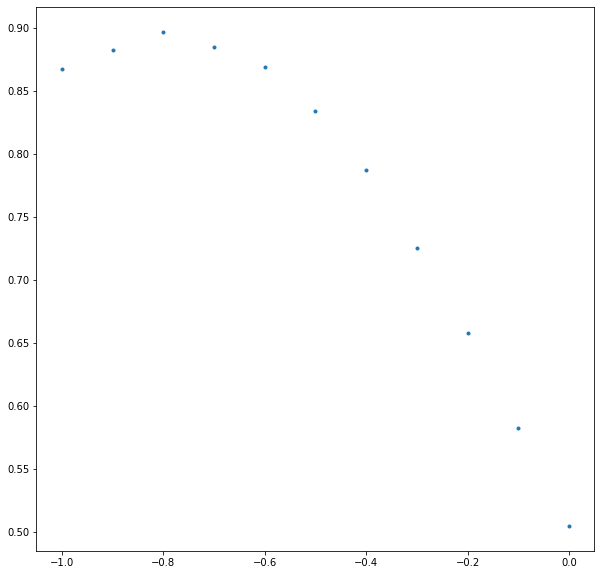

In [9]:
plt.figure(figsize=(10,10))
plt.plot(basics.actions[0],q0,'.')

In [86]:
qn_l1_prim = QN_l1(basics.actions[0])
qn_l1_targ = QN_l1(basics.actions[0])
qn_guess_prim = QN_guess_kennedy(basics.possible_phases)
qn_guess_targ = QN_guess_kennedy(basics.possible_phases)


qvalues1_init = qn_l1_prim(np.expand_dims(np.array([]), axis=0))
qvalues1targ_init = qn_l1_targ(np.expand_dims(np.array([]), axis=0))
qvalueslayerguess_prim_init = qn_guess_prim(np.expand_dims(np.array([1,-.7]), axis=0))
qvalueslayerguess_targ_init = qn_guess_targ(np.expand_dims(np.array([1,-.7]), axis=0))

In [87]:
TAU = 0.1
batch_length = int(buffer.num_samples/10**2)
optimizers = [tf.keras.optimizers.SGD(lr = 1/buffer.num_samples), tf.keras.optimizers.SGD(lr = 1/buffer.num_samples)]
time=1

for _ in tqdm(range(1000)):

    batch = buffer.sample(batch_length)


    outcome_1_beta1_batch = np.array([[ int(v[0]), v[1]] for v in batch ] )
    labels_beta1 = np.array([int(v[2]) for v in batch])


    q_guess_prim = qn_guess_prim(np.expand_dims(outcome_1_beta1_batch, axis=0))
    q_guess_prim = np.squeeze(q_guess_prim.numpy())

    opt_a_2_prim = np.argmax(q_guess_prim,axis=1)

    update_for_q_1_prim = qn_l1_targ(np.expand_dims(np.array([[] for i in range(len(batch))]), axis=0)) #targ = target
    update_for_q_1_prim = np.squeeze(update_for_q_1_prim, axis=0)
    qlabels_l1 = update_for_q_1_prim.copy()

    qlabels_l1[np.arange(batch_length), labels_beta1] = np.squeeze(qn_guess_targ(np.expand_dims(outcome_1_beta1_batch, axis=0)).numpy())[np.arange(batch_length),opt_a_2_prim]
    
    f = np.max([0.0001,np.exp(-time/1000)])
    
    for opts in optimizers:
        opts.__setattr__("learning_rate", f)
    optimizer_ql1, optimizer_guess = optimizers

    train_vars_in = [ch.numpy() for ch in qn_l1_prim.trainable_variables]


    s_3_batch = np.array([[v[0], v[1] ] for v in batch])
    rewards = np.array([v[-1] for v in batch])
    labels_guess = np.array([int(v[-2]) for v in batch])

    update_for_q_3_prim = qn_guess_targ(np.expand_dims(s_3_batch, axis=0))
    update_for_q_3_prim = np.squeeze(update_for_q_3_prim, axis=0)
    qlabels_l3 = update_for_q_3_prim.copy()
    qlabels_l3[np.arange(batch_length), labels_guess] = rewards[np.arange(batch_length)]

    # print(qlabels_l1)
    with tf.device("/cpu:0"):
        with tf.GradientTape() as tape:
            tape.watch(qn_l1_prim.trainable_variables)
            pred_q_1s = qn_l1_prim(np.expand_dims(np.array([[] for i in range(len(batch))]), axis=0))

            loss_sum =tf.keras.losses.MSE(pred_q_1s, qlabels_l1)
            loss = tf.reduce_mean(loss_sum)
            grads = tape.gradient(loss, qn_l1_prim.trainable_variables)
            optimizer_ql1.apply_gradients(zip(grads, qn_l1_prim.trainable_variables))

        with tf.GradientTape() as tape:
            tape.watch(qn_guess_prim.trainable_variables)
            pred_q_3s = qn_guess_prim(np.expand_dims(s_3_batch, axis=0))
            loss_sum =tf.keras.losses.MSE(pred_q_3s, qlabels_l3)
            loss = tf.reduce_mean(loss_sum)
            loss_guess = loss
            grads = tape.gradient(loss, qn_guess_prim.trainable_variables)
            optimizer_guess.apply_gradients(zip(grads, qn_guess_prim.trainable_variables))

    for t, e in zip(qn_l1_targ.trainable_variables, qn_l1_prim.trainable_variables):
        t.assign(t*(1-TAU) + e*TAU)

    for t, e in zip(qn_guess_targ.trainable_variables, qn_guess_prim.trainable_variables):
        t.assign(t*(1-TAU) + e*TAU)
    time+=10
    
        #for opt in optimizers:
         #   opt.learning_rate.value = np.max(0.01, np.exp(-time/100))

100%|██████████| 1000/1000 [01:57<00:00,  8.51it/s]


In [84]:
f

0.001

In [88]:

qvalues1 = qn_l1_prim(np.expand_dims(np.array([]), axis=0))
qvalues1targ = qn_l1_targ(np.expand_dims(np.array([]), axis=0))
qvalueslayerguess_prim = qn_guess_prim(np.expand_dims(np.array([1,-.7]), axis=0))
qvalueslayerguess_targ = qn_guess_targ(np.expand_dims(np.array([1,-.7]), axis=0))


In [10]:
import matplotlib.pyplot as plt

In [89]:
qvalues1 - qvalues1_init

<tf.Tensor: id=1705404, shape=(1, 11), dtype=float64, numpy=
array([[0.64334814, 0.68795908, 0.61906865, 0.64839602, 0.60142488,
        0.53831416, 0.5832813 , 0.44450371, 0.43342835, 0.44459206,
        0.48519492]])>

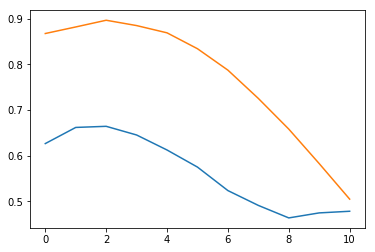

In [118]:
plt.figure(figsize=(20,20))
plt.plot(qvalues1.numpy()[0], label="Neural Network")
plt.plot(q0, label="TAbular Q-learning with lr = 1/N[beta]")
plt.savefig("fiorst_layer_NN.png")

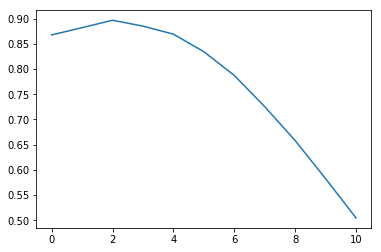

In [102]:
plt.plot(q0)

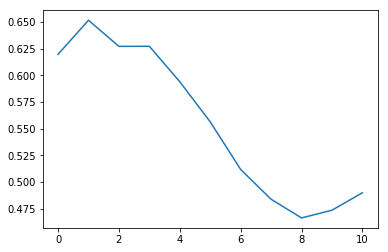

In [60]:
plt.plot(qvalues1targ.numpy()[0])

In [91]:
qvalueslayerguess_prim = np.array([qn_guess_prim(np.expand_dims(np.array([1,beta]), axis=0)).numpy()[0] for beta in np.arange(-1,1.1,.1)])

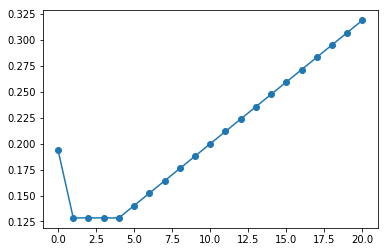

In [92]:
plt.plot(qvalueslayerguess_prim[:,0], '-o')

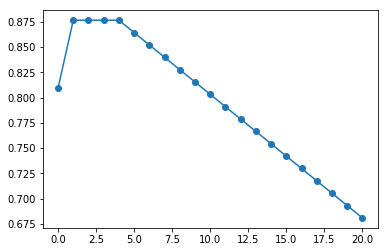

In [94]:
plt.plot(qvalueslayerguess_prim[:,1], '-o')

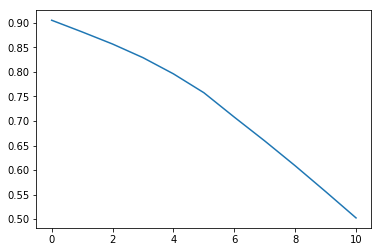

In [98]:
plt.plot(q[0,:,0])

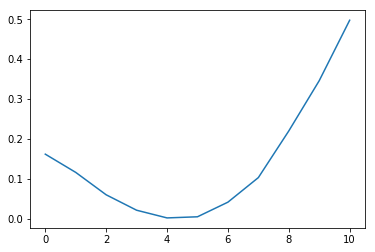

In [99]:
plt.plot(q[1,:,0])

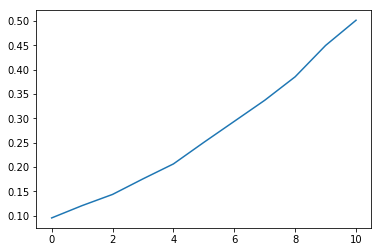

In [100]:
plt.plot(q[0,:,1])

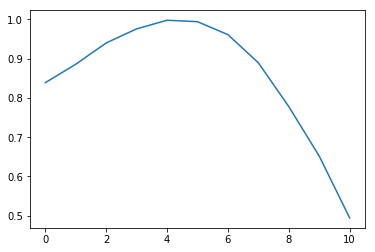

In [101]:
plt.plot(q[1,:,1])

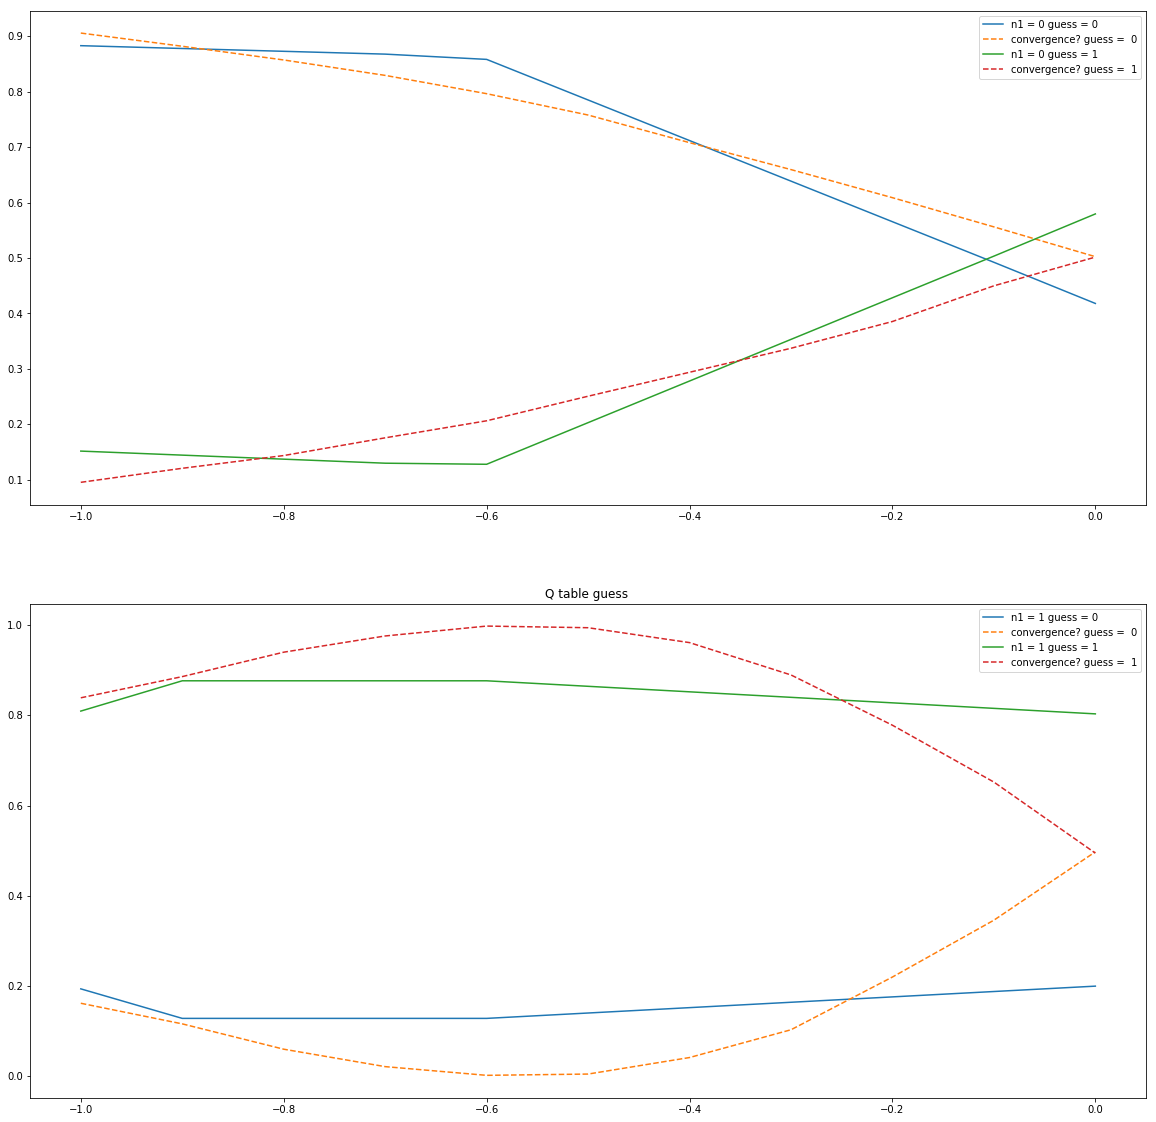

In [117]:
plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((2,1),(0,0))
ax2 = plt.subplot2grid((2,1),(1,0))


axes= {"1": ax1, "2":ax2}

for n1 in [0,1]:
    for guess in [0,1]:
        
        qvalueslayerguess_prim = np.array([qn_guess_prim(np.expand_dims(np.array([n1,beta]), axis=0)).numpy()[0] for beta in basics.actions[0]])
        axes[str(n1+1)].plot(basics.actions[0], qvalueslayerguess_prim[:,guess], label="n1 = " + str(n1) + " guess = "+str(guess))
        axes[str(n1+1)].plot(basics.actions[0], q[n1, :, guess], '--', label="convergence? guess =  "+str(guess) )
        axes[str(n1+1)].legend()
        
plt.title("Q table guess ")
plt.savefig("guess_q_table.png")

array([0.88277958, 0.15174695])